### **Homework 2 - Image Segmentation**

In [1]:
#IMPORT USEFUL LIBRARIES

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import math
from matplotlib import pyplot

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage
from skimage import transform

from keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.python.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose
from tensorflow.python.keras.models import Sequential

In [2]:
#SET RANDOM SEED
SEED = 1234
tf.random.set_seed(SEED)  
cwd = os.getcwd()

In [3]:
#GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
#UNZIP DATASET FOLDER
!unzip '/content/drive/My Drive/Development_Dataset.zip'

Archive:  /content/drive/My Drive/Development_Dataset.zip
  inflating: Development_Dataset/LICENSE.txt  
   creating: Development_Dataset/Test_Dev/
   creating: Development_Dataset/Test_Dev/Bipbip/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflating: Developm

In [5]:
#SET IMAGE TRAINING SHAPE
img_h = 512
img_w = 512

out_shape = [img_h, img_w]

In [6]:
#SET DIRECTORIES

dataset_dir = os.path.join(cwd, '/content/Development_Dataset/')

training_dir = os.path.join(dataset_dir, 'Training/Bipbip/Mais/') #to modify each time we want to use a different training/valid set

dataset_dir
training_dir

mask_dir =  os.path.join(dataset_dir, 'Training/Bipbip/Mais/Masks/') #to modify each time we want to use a different training/valid set
mask_dir

test_dir = os.path.join(dataset_dir, 'Test_Dev/')
test_dir

prediction_dir = os.path.join('/content/drive/My Drive', "predictions")
if (not os.path.exists(prediction_dir)):
  os.makedirs(prediction_dir)
prediction_dir

'/content/Development_Dataset/'

'/content/Development_Dataset/Training/Bipbip/Mais/'

'/content/Development_Dataset/Training/Bipbip/Mais/Masks/'

'/content/Development_Dataset/Test_Dev/'

'/content/drive/My Drive/predictions'

In [7]:
#DATA GENERATORS

img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=5,
                                      height_shift_range=5,
                                      zoom_range=0,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=5,
                                       height_shift_range=5,
                                       zoom_range=0,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [8]:
#FUNCTION TO CONVERT DATASET (RGB) MASKS INTO TRAINING MASKS (ONE CLASS PER PIXEL)
def read_rgb_mask(mask_img):
    
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [9]:
#DATA PREPROCESSING

validation_split = 0.8

img_arr = []
mask_arr = []

#DATASET ARRAY CREATION

for img in os.listdir(os.path.join(training_dir, "Images")):
  print(img)

  img_path = os.path.join(training_dir, "Images", img)
  image = Image.open(img_path)

  mask_path = os.path.join(training_dir, "Masks", os.path.splitext(img)[0] + '.png') #take mask with the same name of the image
  assert(os.path.exists(mask_path))
  mask = Image.open(mask_path)

  # RESIZE
  image = image.resize(out_shape)

  mask = mask.resize(out_shape)

  #TO NUMPY ARRAY
  image = np.array(image)
  mask = np.array(mask)

  #TRANFORM
  img_y = img_data_gen.get_random_transform(out_shape, seed=SEED)
  mask_t = mask_data_gen.get_random_transform(out_shape, seed=SEED)
  image = img_data_gen.apply_transform(image, img_y)
  mask = mask_data_gen.apply_transform(mask, mask_t)

  #APPLY READ_RGB_MASK FUNCTION
  mask = read_rgb_mask(mask)

  #APPEND ALL IMAGES AND MASKS
  img_arr.append(image)
  mask_arr.append(mask)

  
    
  #END FOR

#DIVIDE TRAIN AND VALIDATION ARRAYS
bound = math.floor(len(img_arr)*validation_split)
train_img_array = img_arr[: bound]
valid_img_array = img_arr[bound :]

train_mask_array = mask_arr[: bound]
valid_mask_array = mask_arr[bound :]




Bipbip_mais_im_04781.jpg
Bipbip_mais_im_09501.jpg
Bipbip_mais_im_10691.jpg
Bipbip_mais_im_05691.jpg
Bipbip_mais_im_03581.jpg
Bipbip_mais_im_11121.jpg
Bipbip_mais_im_09641.jpg
Bipbip_mais_im_03231.jpg
Bipbip_mais_im_07181.jpg
Bipbip_mais_im_02151.jpg
Bipbip_mais_im_01601.jpg
Bipbip_mais_im_03921.jpg
Bipbip_mais_im_03751.jpg
Bipbip_mais_im_07041.jpg
Bipbip_mais_im_10231.jpg
Bipbip_mais_im_10371.jpg
Bipbip_mais_im_08661.jpg
Bipbip_mais_im_01681.jpg
Bipbip_mais_im_05801.jpg
Bipbip_mais_im_04501.jpg
Bipbip_mais_im_05281.jpg
Bipbip_mais_im_03181.jpg
Bipbip_mais_im_07911.jpg
Bipbip_mais_im_08441.jpg
Bipbip_mais_im_07531.jpg
Bipbip_mais_im_04911.jpg
Bipbip_mais_im_08261.jpg
Bipbip_mais_im_10001.jpg
Bipbip_mais_im_03291.jpg
Bipbip_mais_im_03691.jpg
Bipbip_mais_im_07271.jpg
Bipbip_mais_im_02371.jpg
Bipbip_mais_im_07991.jpg
Bipbip_mais_im_05871.jpg
Bipbip_mais_im_01751.jpg
Bipbip_mais_im_03811.jpg
Bipbip_mais_im_08511.jpg
Bipbip_mais_im_07761.jpg
Bipbip_mais_im_06961.jpg
Bipbip_mais_im_08381.jpg


In [10]:
#CONVERT LIST TO NP ARRAYS
train_img_array = np.array(train_img_array)
train_mask_array = np.array(train_mask_array)
valid_img_array = np.array(valid_img_array)
valid_mask_array = np.array(valid_mask_array)

In [11]:
#TEST IMAGES
img_arr = []
for crop_group in os.listdir(test_dir):
  for crop_type in os.listdir(test_dir + crop_group):
     for img in os.listdir(test_dir + crop_group + "/" + crop_type + "/Images"): 
        print(img)
        #GET IMAGE
        img_path = os.path.join(test_dir + crop_group + "/" + crop_type + "/Images/", img)
        image = Image.open(img_path)

        #RESIZE IMAGE AND MASK
        image = image.resize(out_shape)
        image = np.array(image)
        
        #APPEND TO A LIST
        img_arr.append(image)
  
#LIST TO NP ARRAY
test_img_array= np.array(img_arr)

Weedelec_haricot_2019-09-25T114852-119.jpg
Weedelec_haricot_2019-09-25T115942-370.jpg
Weedelec_haricot_2019-09-25T120248-442.jpg
Weedelec_haricot_2019-09-25T120146-418.jpg
Weedelec_haricot_2019-09-25T114419-14.jpg
Weedelec_haricot_2019-09-25T115142-185.jpg
Weedelec_haricot_2019-09-25T114537-44.jpg
Weedelec_haricot_2019-09-25T114608-56.jpg
Weedelec_haricot_2019-09-25T114347-2.jpg
Weedelec_haricot_2019-09-25T114726-86.jpg
Weedelec_haricot_2019-09-25T120225-433.jpg
Weedelec_haricot_2019-09-25T115906-356.jpg
Weedelec_haricot_2019-09-25T115628-295.jpg
Weedelec_haricot_2019-09-25T114558-52.jpg
Weedelec_haricot_2019-09-25T115031-157.jpg
Weedelec_mais_2019-09-25T121237-165.jpg
Weedelec_mais_2019-09-25T122227-395.jpg
Weedelec_mais_2019-09-25T121539-235.jpg
Weedelec_mais_2019-09-25T122021-345.jpg
Weedelec_mais_2019-09-25T121851-310.jpg
Weedelec_mais_2019-09-25T121133-140.jpg
Weedelec_mais_2019-09-25T121350-193.jpg
Weedelec_mais_2019-09-25T121800-290.jpg
Weedelec_mais_2019-09-25T121103-128.jpg
We

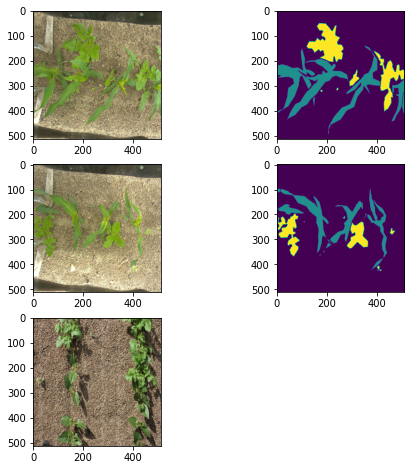

In [12]:
#VISUALIZE IMAGES AND MASKS
fig=pyplot.figure(figsize=(8, 8))
h = 3
w = 2

#MODIFY THESE PARAMETERS TO EXPLORE THE ARRAYS
m = 0
n = 0
p = 0

fig.add_subplot(h, w, 1)
pyplot.imshow(train_img_array[m])
fig.add_subplot(h, w, 2)
pyplot.imshow(train_mask_array[m])

fig.add_subplot(h, w, 3)
pyplot.imshow(valid_img_array[n])
fig.add_subplot(h, w, 4)
pyplot.imshow(valid_mask_array[n])

fig.add_subplot(h, w, 5)
pyplot.imshow(test_img_array[p])

In [13]:
#CREATE DATASETS

#SET BATCH SIZE
bs= 8

train_mask_array = tf.expand_dims(train_mask_array, -1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_array, train_mask_array))
train_dataset = train_dataset.batch(bs)
train_dataset = train_dataset.repeat()

valid_mask_array = tf.expand_dims(valid_mask_array, -1)
val_dataset = tf.data.Dataset.from_tensor_slices((valid_img_array, valid_mask_array))
val_dataset = val_dataset.batch(bs)
val_dataset = val_dataset.repeat()

test_dataset = tf.data.Dataset.from_tensors(test_img_array)

print(train_dataset)
print(val_dataset)
print(test_dataset)

<RepeatDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.uint8, tf.uint8)>
<RepeatDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.uint8, tf.uint8)>
<TensorDataset shapes: (120, 512, 512, 3), types: tf.uint8>


[]

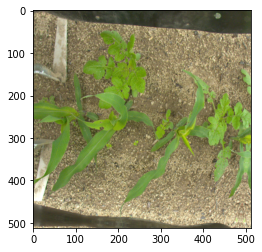

In [ ]:
#VISUALIZE TRAIN DATASET

#VisualizeTrainSet
import matplotlib.pyplot as plt
%matplotlib inline
TrainIterator = iter(train_dataset)
train_augmented_img, target = next(TrainIterator)
train_augmented_img = np.array(train_augmented_img[0])
train_augmented_img = train_augmented_img 
plt.imshow(np.uint8(train_augmented_img))
plt.plot()

[]

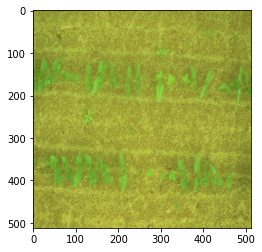

In [ ]:
#VISUALIZE VALID DATASET

#VisualizeValidSet
import matplotlib.pyplot as plt
%matplotlib inline

ValidIterator = iter(val_dataset)
valid_augmented_img, target = next(ValidIterator)
valid_augmented_img = np.array(valid_augmented_img[0])
valid_augmented_img = valid_augmented_img 
plt.imshow(np.uint8(valid_augmented_img))

plt.plot()

[]

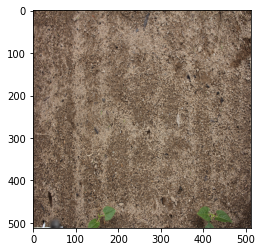

In [ ]:
#VISUALIZE TESTDATASET
import matplotlib.pyplot as plt
%matplotlib inline

TestIterator = iter(test_dataset)
test_augmented_img = next(TestIterator)
test_augmented_img = np.array(test_augmented_img[2])
test_augmented_img = test_augmented_img 
plt.imshow(np.uint8(test_augmented_img))

plt.plot()

In [ ]:
def create_trivial_model( im_shape, depth, start_f, num_classes):

    model = tf.keras.Sequential()
    vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=im_shape)

    for layer in vgg.layers:
      layer.trainable = False

    model.add(vgg)
    
    # Encoder
    # -------
    start_f = 256 #256
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2
    
    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [14]:
#UNET MODEL

#Convolution Block

def __conv_block(input_tensor, num_filters, kernel_size=3):
    # First layer
    encoder = Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size), padding='same')(input_tensor)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    # Second layer
    encoder = Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)

    return encoder


# Encoder block

def __encoder_block(input_tensor, num_filters, pool_size=2, strides=2):
    # Encoder
    encoder = __conv_block(input_tensor, num_filters)
    encoder_pool = MaxPooling2D(pool_size=(pool_size, pool_size), strides=(strides, strides))(encoder)

    return encoder_pool, encoder


# Decoder block

def __decoder_block(input_tensor, concat_tensor, num_filters, kernel_size=3, transpose_kernel_size=2, strides=2):
    # Conv2DTranspose AKA Deconvolution
    decoder = Conv2DTranspose(filters=num_filters, kernel_size=(transpose_kernel_size, transpose_kernel_size),
                              strides=(strides, strides), padding='same')(input_tensor)
    # Concatenate
    decoder = concatenate([concat_tensor, decoder], axis=-1)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(num_filters, (kernel_size, kernel_size), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(num_filters, (kernel_size, kernel_size), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    return decoder


# BUILD THE MODEL

def get_unet_model(img_shape):
    print("Setting up the model")
    base_n_filters = 32  # The "minimum" number of filters (filters in first encoder)

    # Input
    inputs = Input(shape=img_shape)

    # Encoders
    encoder0_pool, encoder0 = __encoder_block(inputs, base_n_filters) 
    encoder1_pool, encoder1 = __encoder_block(encoder0_pool, base_n_filters*2) 
    encoder2_pool, encoder2 = __encoder_block(encoder1_pool, base_n_filters*4) 
    encoder3_pool, encoder3 = __encoder_block(encoder2_pool, base_n_filters*8)
    encoder4_pool, encoder4 = __encoder_block(encoder3_pool, base_n_filters*16)
    print("Encoders created")

    # Center
    center = __conv_block(encoder4_pool, base_n_filters*32)  # 1024
    print("Center created")

    # Decoders
    decoder4 = __decoder_block(center, encoder4, base_n_filters*16)
    decoder3 = __decoder_block(decoder4, encoder3, base_n_filters*8)
    decoder2 = __decoder_block(decoder3, encoder2, base_n_filters*4)
    decoder1 = __decoder_block(decoder2, encoder1, base_n_filters*2)
    decoder0 = __decoder_block(decoder1, encoder0, base_n_filters)
    print("Decoders created")

    # Output
    outputs = Conv2D(3, (1, 1), activation='softmax')(decoder0)  # 3 classi

    # Create model
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [15]:
#CREATE THE MODEL

#CREATE THE UNET MODEL
im_shape = [None, None, 3]
model = get_unet_model(im_shape)

#VISUALIZE MODEL
model.summary()

'\nim_shape = (train_img_array.shape[1:])\n\nmodel = create_trivial_model(im_shape = im_shape,\n                    depth=5, \n                    start_f=8, \n                    num_classes=3)\n'

Setting up the model
Encoders created
Center created
Decoders created
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
________________________

In [16]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):

    per_class_iou = []

    for i in range(1,3):
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = [meanIoU, 'accuracy']
# ------------------



In [17]:
#CALLBACKS

ckpt_dir = os.path.join(dataset_dir, "checkpoints")
if (not os.path.exists(ckpt_dir)):
  os.makedirs(ckpt_dir)# Model checkpoint

tb_dir = os.path.join(dataset_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)

# ----------------
callbacks = []

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True, restore_best_weights=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', restore_best_weights=True,patience=10)
    callbacks.append(es_callback)

In [18]:
#COMPILE THE MODEL
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [25]:
#TRAIN THE MODEL
model.fit(x = train_dataset, 
          epochs = 30,
          steps_per_epoch = len(train_img_array),
          batch_size = bs,
          validation_data = val_dataset,
          validation_steps = len(valid_img_array),
          callbacks=callbacks)

Epoch 1/30
72/72 [==============================] - 90s 1s/step - loss: 0.0819 - meanIoU: 7.1785e-05 - accuracy: 0.9744 - val_loss: 3.3580 - val_meanIoU: 0.0148 - val_accuracy: 0.5977
Epoch 2/30
72/72 [==============================] - 90s 1s/step - loss: 0.0645 - meanIoU: 3.7470e-06 - accuracy: 0.9768 - val_loss: 0.2478 - val_meanIoU: 6.5036e-12 - val_accuracy: 0.9253
Epoch 3/30
72/72 [==============================] - 90s 1s/step - loss: 0.0525 - meanIoU: 1.1513e-12 - accuracy: 0.9798 - val_loss: 0.0876 - val_meanIoU: 6.5072e-12 - val_accuracy: 0.9689
Epoch 4/30
72/72 [==============================] - 90s 1s/step - loss: 0.0481 - meanIoU: 1.1513e-12 - accuracy: 0.9809 - val_loss: 0.0694 - val_meanIoU: 6.5072e-12 - val_accuracy: 0.9744
Epoch 5/30
72/72 [==============================] - 90s 1s/step - loss: 0.0465 - meanIoU: 1.0497e-04 - accuracy: 0.9813 - val_loss: 0.1115 - val_meanIoU: 6.5072e-12 - val_accuracy: 0.9646
Epoch 6/30
72/72 [==============================] - 90s 1s/step 

In [26]:
#PREDICT WITH TEST_IMG_ARRAY

pred = model.predict(x = test_img_array)
pred.shape

predictions = tf.argmax(pred,-1)
predictions

(120, 512, 512, 3)

<tf.Tensor: shape=(120, 512, 512), dtype=int64, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0,

In [21]:
#RLE ENCODE FUNCTION
def rle_encode(img):
    
    #img: numpy array, 1 - foreground, 0 - background
    #Returns run length as string formatted

    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [22]:
#UTIL FUNCTION FOR DICTIONARY
def convertTuple(tup): 
    s = "(" + ', '.join(map(str,tup)) + ")" 
    return s

# Submission Part
Note that those strange numbers in the rle_encode lines of code are there (instead of "1" and "2") because skimage.tranform.resize function tranform the "1"s and "2"s in that numbers. We don't know why. Anyway the reshape and the encoding are correct.

In [27]:
#SUBMISSION
submission_dict = {}
i=0
for crop_group in os.listdir(test_dir):
  for crop_type in os.listdir(test_dir + crop_group):
     for img in os.listdir(test_dir + crop_group + "/" + crop_type + "/Images"): 
        
        #GET IMAGE
        img_path = os.path.join(test_dir + crop_group + "/" + crop_type + "/Images/", img)
        image = Image.open(img_path)
        
        #IMAGE NAME
        image_name  = img[0:-4]
        #IMAGE DIMENSIONS
        image_shape = image.size
        #TAKE IMAGE PREDICTION
        image_prediction = predictions[i]
        image_prediction = np.array(image_prediction)

        #SWAP WIDTH AND HEIGHT FOR SKIMAGE RESIZE FUNCTION
        true_w = image_shape[0]
        true_h = image_shape[1]
        true_image_shape = (true_h, true_w)

        #RESHAPE TO ORIGINAL DIMENSIONS THE PREDICTION
        image_prediction_reshaped = skimage.transform.resize(image_prediction, true_image_shape, order = 0)

        #COMPUTE RLE ENCODING
        #CROP RLE
        rle_encoded_crop = rle_encode(image_prediction_reshaped == 1.6263032587282567e-19)
        #WEED RLE
        rle_encoded_weed = rle_encode(image_prediction_reshaped == 2.710505431213761e-19)

        #CREAT THE SUBMISSION DICTIONARY
        submission_dict[image_name] = {}
        submission_dict[image_name]['shape'] = "[" + convertTuple(image_shape)[1:-1] + "]"
        submission_dict[image_name]['team'] = crop_group
        submission_dict[image_name]['crop'] = crop_type
        submission_dict[image_name]['segmentation'] = {}

        submission_dict[image_name]['segmentation']['crop'] = rle_encoded_crop
        submission_dict[image_name]['segmentation']['weed'] = rle_encoded_weed

        i = i + 1

#CREATE JSON SUBMISION FILE
delivery_folder = os.path.join(prediction_dir, "output-15")
if (not os.path.exists(delivery_folder)):
  os.makedirs(delivery_folder)

with open(os.path.join(delivery_folder, "submission.json"), 'w') as f:
  json.dump(submission_dict, f)